# 센서 데이터 클러스터링 분석

이 노트북은 CO₂, 온도, 습도 데이터를 전처리하고 KMeans 클러스터링을 수행한 뒤, 도메인 검증을 위한 절차를 담고 있습니다.

## 1) 라이브러리 임포트 및 폰트 설정

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name


## 2) 데이터 로드 및 전처리

In [4]:
df = pd.read_csv("./sensor_data_pivot.csv", parse_dates=['time'])
df.head()

,time,location,co2,humidity,temperature
0,2025-04-25 00:05:00+00:00,8인 책상,481.400000,25.6,23.660000
1,2025-04-25 00:05:00+00:00,보드,562.000000,41.5,23.600000
2,2025-04-25 00:05:00+00:00,왼쪽 뒤,556.000000,35.0,23.166667
3,2025-04-25 00:10:00+00:00,8인 책상,491.800000,26.6,23.780000
4,2025-04-25 00:10:00+00:00,보드,550.333333,41.5,23.533333


## area 매핑 및 파생 변수 생성

In [5]:
area_map = {
    "8인 책상": 64.65,
    "왼쪽 뒤": 109.21,
    "안쪽벽 중앙": 25.13,
    "보드": 31.59
}
df['area'] = df['location'].map(area_map)
df = df.dropna(subset=['area'])
df['co2_per_area'] = df['co2'] / df['area']

## 결측치 처리

In [6]:
imputer = IterativeImputer(random_state=42)
df[['co2', 'temperature', 'humidity']] = imputer.fit_transform(
    df[['co2', 'temperature', 'humidity']]
)
df = df.dropna(subset=['co2_per_area'])

In [7]:
df.isna().sum()

time            0
location        0
co2             0
humidity        0
temperature     0
area            0
co2_per_area    0
dtype: int64

## 데이터 증강

In [8]:
def gen_proto(n, mean, std, areas):
    df_s = pd.DataFrame({
        'co2': np.random.normal(mean[0], std[0], n),
        'temperature': np.random.normal(mean[1], std[1], n),
        'humidity': np.random.normal(mean[2], std[2], n),
    })
    df_s['co2_per_area'] = df_s['co2'] / np.random.choice(areas, n)
    return df_s

areas = df['area'].unique()
specs = [
    ([850, 19, 35], [200, 1, 5]),   # 춥고 건조
    ([1200, 27, 65], [300, 1, 5])   # 덥고 습함
]
synth = pd.concat([gen_proto(2000, m, s, areas) for m, s in specs], ignore_index=True)
df = pd.concat([df, synth], ignore_index=True)


In [9]:
# 불필요 컬럼 제거
df = df.drop(columns=['time', 'location', 'area'])


## 이상치 제거

In [10]:
for col in ['temperature', 'humidity', 'co2_per_area']:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)


## 특성 행렬 구성 및 스케일링

In [11]:
features = ['co2', 'temperature', 'humidity', 'co2_per_area']
X = df[features].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 3) KMeans 클러스터링 및 최적 k 탐색 (엘보우)

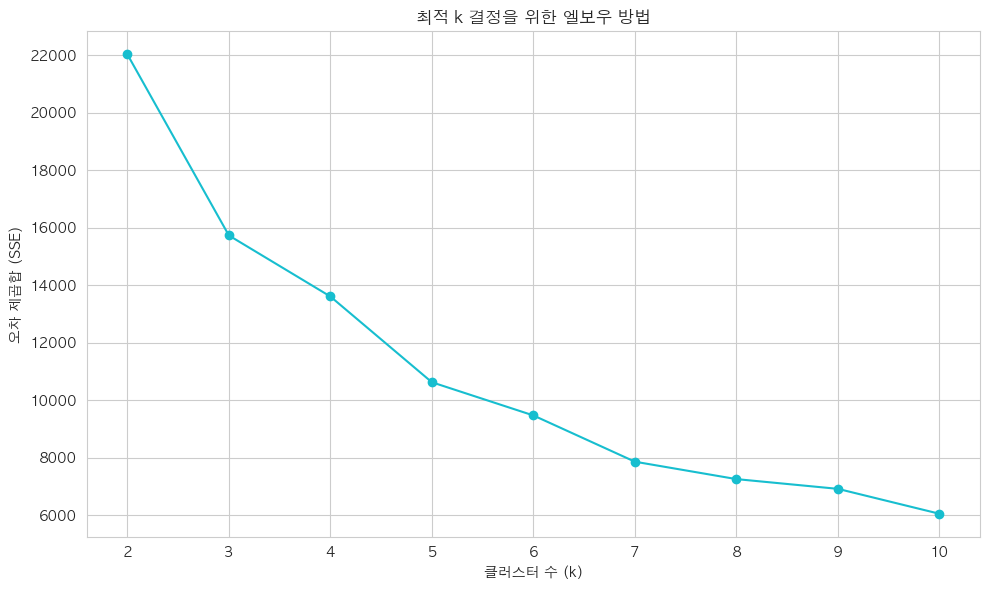

In [12]:
Ks = range(2, 11)
sse = []
for k in Ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, algorithm="elkan")
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(Ks, sse, marker='o', color='#17becf')
plt.xlabel('클러스터 수 (k)')
plt.ylabel('오차 제곱합 (SSE)')
plt.title('최적 k 결정을 위한 엘보우 방법')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4) 최적 k=3로 클러스터링 및 평가

In [13]:
k_opt = 3
km = KMeans(n_clusters=k_opt, init='k-means++', random_state=42, algorithm="elkan")
labels = km.fit_predict(X)
df['cluster'] = labels

## 클러스터 중심 복원


In [14]:
centers_orig = scaler.inverse_transform(km.cluster_centers_)
centers = pd.DataFrame(centers_orig, columns=features)

## 실루엣 스코어 출력

In [15]:
sil_score = silhouette_score(X, labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.43128198881368657


# PCA 시각화

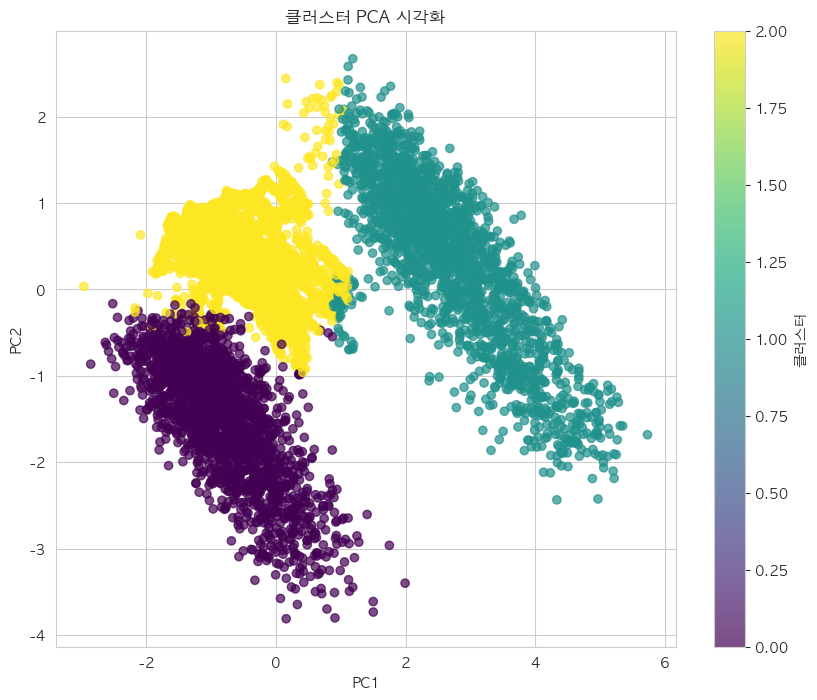

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title('클러스터 PCA 시각화')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='클러스터')
plt.show()

## 5) 도메인 검증

In [17]:
# CO2 상태 컬럼
df['co2_status'] = np.where(df['co2'] > 1000, 'CO2 주의', 'CO2 양호')

# 검증용 피처
check_feats = ['co2', 'temperature', 'humidity', 'co2_per_area']

# 라벨 매핑
mapping = {0: '춥고 건조', 1: '덥고 습함', 2: '최적 쾌적'}
df['cluster_label'] = df['cluster'].map(mapping)

# 검증용 피처 리스트
check_feats = ['co2','temperature','humidity','co2_per_area']

# 클러스터별 요약 통계
print("=== 클러스터별 요약 통계 ===")
print(df.groupby('cluster_label')[check_feats].agg(['mean','min','max','std']))


=== 클러스터별 요약 통계 ===
                       co2                                      temperature  \
                      mean         min          max         std        mean   
cluster_label                                                                 
덥고 습함          1214.448886  429.264509  2350.404899  279.569383   26.849523   
최적 쾌적           603.231008  116.552307  1343.333333  164.254082   23.969343   
춥고 건조           849.534322  125.489684  1575.851105  195.263786   18.958288   

                                                humidity                     \
                     min        max       std       mean     min        max   
cluster_label                                                                 
덥고 습함          23.500000  28.549648  1.041847  64.266872  40.875  73.204566   
최적 쾌적          19.348767  28.389933  1.027929  36.928477  23.000  68.348320   
춥고 건조          17.311741  23.525000  0.950709  35.098667  23.000  53.263126   

                        co2_pe

In [18]:
# 레이블 순서 지정
labels = ['춥고 건조','최적 쾌적','덥고 습함']
df['cluster_label'] = pd.Categorical(df['cluster_label'], categories=labels, ordered=True)

# 클러스터별 랜덤 샘플 5개씩 출력
for label in labels:
    print(f"\n--- 샘플: {label} ---")
    print(
        df[df['cluster_label']==label]
          [check_feats + ['co2_status']]
          .sample(5, random_state=42)
          .to_string(index=False)
    )


--- 샘플: 춥고 건조 ---
        co2  temperature  humidity  co2_per_area co2_status
 589.602950    18.664226 32.167655      5.398800     CO2 양호
 869.025774    19.480774 42.290516      7.957383     CO2 양호
 792.955799    19.473576 37.043794     25.101481     CO2 양호
1099.009675    19.403201 32.934277     34.789797     CO2 주의
 925.910107    18.264314 34.426208     14.321889     CO2 양호

--- 샘플: 최적 쾌적 ---
   co2  temperature  humidity  co2_per_area co2_status
942.50       24.450     41.00      8.630162     CO2 양호
511.00       23.800     36.00      4.679059     CO2 양호
522.25       24.025     37.75     16.532130     CO2 양호
510.25       23.700     30.50      4.672191     CO2 양호
465.80       23.780     32.00      7.204950     CO2 양호

--- 샘플: 덥고 습함 ---
        co2  temperature  humidity  co2_per_area co2_status
1168.054206    28.203371 61.749844     36.975442     CO2 주의
1306.708319    25.767669 58.168964     41.364619     CO2 주의
 977.977034    26.297519 73.057191      8.955014     CO2 양호
1429.117768  

In [19]:
df

,co2,humidity,temperature,co2_per_area,cluster,co2_status,cluster_label
0,481.400000,25.600000,23.660000,7.446249,2,CO2 양호,최적 쾌적
1,562.000000,41.500000,23.600000,17.790440,2,CO2 양호,최적 쾌적
2,556.000000,35.000000,23.166667,5.091109,2,CO2 양호,최적 쾌적
3,491.800000,26.600000,23.780000,7.607115,2,CO2 양호,최적 쾌적
4,550.333333,41.500000,23.533333,17.421125,2,CO2 양호,최적 쾌적
...,...,...,...,...,...,...,...
10093,1487.570778,72.138914,27.710920,47.089927,1,CO2 주의,덥고 습함
10094,1243.410225,56.783994,26.510012,19.232950,1,CO2 주의,덥고 습함
10095,1010.440260,65.303977,27.587214,15.629393,1,CO2 주의,덥고 습함
10096,1178.594643,66.794218,26.640388,10.792003,1,CO2 주의,덥고 습함


In [20]:
df.to_csv('labeled_sensor_data.csv', index=False)